# End-to-End Benchmark

Run QuASAr and baseline backends on benchmark circuits and compare performance.

In [1]:
import os, sys
sys.path.append(os.path.abspath('../..'))
import pandas as pd
from benchmarks.runner import BenchmarkRunner
from quasar.backends import StatevectorBackend
from benchmarks.backends import DecisionDiagramAdapter, MPSAdapter, StimAdapter
from benchmarks import circuits
from quasar.simulation_engine import SimulationEngine
from quasar_convert import ConversionEngine
import time, matplotlib.pyplot as plt

In [2]:
class TrackingConversionEngine(ConversionEngine):
    def __init__(self):
        super().__init__()
        self.total_time = 0.0
    def _timeit(self, func, *args, **kwargs):
        start = time.perf_counter()
        res = func(*args, **kwargs)
        self.total_time += time.perf_counter() - start
        return res
    def convert_boundary_to_statevector(self, ssd):
        return self._timeit(super().convert_boundary_to_statevector, ssd)
    def convert_boundary_to_tableau(self, ssd):
        if hasattr(super(), "convert_boundary_to_tableau"):
            return self._timeit(super().convert_boundary_to_tableau, ssd)
        raise AttributeError
    def convert_boundary_to_dd(self, ssd):
        if hasattr(super(), "convert_boundary_to_dd"):
            return self._timeit(super().convert_boundary_to_dd, ssd)
        raise AttributeError
    def extract_local_window(self, state, qubits):
        return self._timeit(super().extract_local_window, state, qubits)
    def build_bridge_tensor(self, left, right):
        return self._timeit(super().build_bridge_tensor, left, right)

In [3]:
circuit_fns = {
    'ghz': circuits.ghz_circuit,
    'qft': circuits.qft_circuit,
    'w_state': circuits.w_state_circuit,
    'grover': circuits.grover_circuit,
}
backends = {
    'statevector': StatevectorBackend(),
    'mqt_dd': DecisionDiagramAdapter(),
    'mps': MPSAdapter(),
    'stim': StimAdapter(),
}
REPETITIONS = 5
NUM_QUBITS = 2
records = []
for cname, cfn in circuit_fns.items():
    circuit = cfn(NUM_QUBITS)
    for bname, backend in backends.items():
        for _ in range(REPETITIONS):
            runner = BenchmarkRunner()
            try:
                rec = runner.run_multiple(circuit, backend, return_state=False, repetitions=3)
            except (NotImplementedError, RuntimeError):
                continue
            rec.update({'circuit': cname, 'backend_switches': 0, 'conversion_time': 0.0})
            records.append(rec)
    for _ in range(REPETITIONS):
        ce = TrackingConversionEngine()
        runner = BenchmarkRunner()
        engine = SimulationEngine(conversion_engine=ce)
        rec = runner.run_quasar(circuit, engine)
        rec.update({'circuit': cname,
                    'backend_switches': len(rec['result'].conversions),
                    'conversion_time': ce.total_time})
        records.append(rec)
df = pd.DataFrame(records)
df['runtime'] = df['total_time_mean'].fillna(df['total_time'])
df['peak_memory'] = df[['prepare_peak_memory', 'run_peak_memory', 'prepare_peak_memory_mean', 'run_peak_memory_mean']].max(axis=1)
summary = df.groupby(['circuit','framework']).agg(
    runtime_mean=('runtime','mean'), runtime_std=('runtime','std'),
    peak_memory_mean=('peak_memory','mean'), peak_memory_std=('peak_memory','std'),
    backend_switches_mean=('backend_switches','mean'),
    backend_switches_std=('backend_switches','std'),
    conversion_time_mean=('conversion_time','mean'),
    conversion_time_std=('conversion_time','std')
).reset_index()
results = summary
ghz_backend = df[(df.circuit == 'ghz') & (df.framework == 'quasar')]['backend'].unique()
assert len(ghz_backend) == 1 and ghz_backend[0].lower() in {'stim', 'tableau'}, f'GHZ routed to {ghz_backend}'
summary


,circuit,framework,runtime_mean,runtime_std,peak_memory_mean,peak_memory_std,backend_switches_mean,backend_switches_std,conversion_time_mean,conversion_time_std
0,ghz,mqt_dd,0.010744,0.014690,1612.000000,17.888544,0.0,0.0,0.0,0.0
1,ghz,quasar,0.003987,0.000483,8318.200000,1127.752943,0.0,0.0,0.0,0.0
2,ghz,stim,0.000139,0.000061,740.333333,0.000000,0.0,0.0,0.0,0.0
3,grover,mqt_dd,0.004687,0.005498,2437.066667,273.377883,0.0,0.0,0.0,0.0
4,grover,quasar,0.067133,0.002243,23592.200000,805.759393,0.0,0.0,0.0,0.0
5,grover,stim,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0
6,qft,mqt_dd,0.002232,0.000424,1607.333333,12.092238,0.0,0.0,0.0,0.0
7,qft,quasar,0.015138,0.000466,31631.400000,30898.491950,0.0,0.0,0.0,0.0
8,qft,stim,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0
9,w_state,mqt_dd,0.002919,0.000333,1610.133333,37.113639,0.0,0.0,0.0,0.0


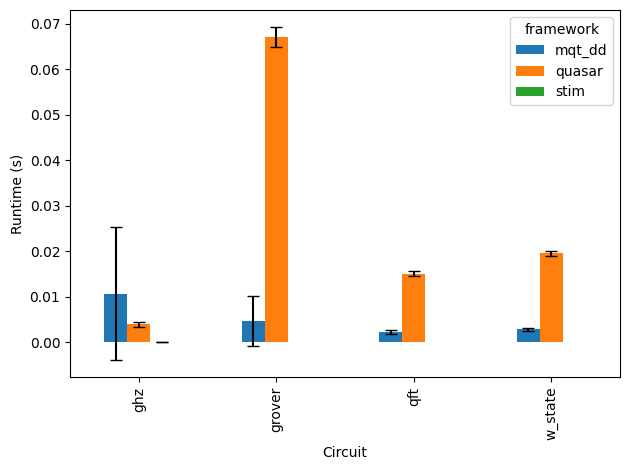

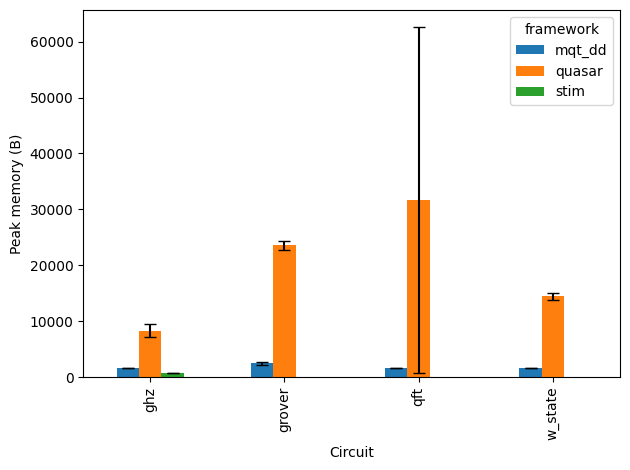

In [4]:
runtime_mean = summary.pivot(index='circuit', columns='framework', values='runtime_mean')
runtime_std = summary.pivot(index='circuit', columns='framework', values='runtime_std')
ax = runtime_mean.plot.bar(yerr=runtime_std, capsize=4)
ax.set_ylabel('Runtime (s)')
ax.set_xlabel('Circuit')
plt.tight_layout()

peak_mean = summary.pivot(index='circuit', columns='framework', values='peak_memory_mean')
peak_std = summary.pivot(index='circuit', columns='framework', values='peak_memory_std')
ax = peak_mean.plot.bar(yerr=peak_std, capsize=4)
ax.set_ylabel('Peak memory (B)')
ax.set_xlabel('Circuit')
plt.tight_layout()


In [5]:
speedup = []
for cname in circuit_fns:
    quasar_time = summary[(summary.circuit==cname)&(summary.framework=='quasar')]['runtime_mean'].iloc[0]
    baseline_times = summary[(summary.circuit==cname)&(summary.framework!='quasar')]['runtime_mean']
    if not baseline_times.empty:
        best_baseline = baseline_times.min()
        speedup.append({'circuit': cname, 'speedup': best_baseline/quasar_time})
speedup_df = pd.DataFrame(speedup)
speedup_df

,circuit,speedup
0,ghz,0.034897
1,qft,0.147448
2,w_state,0.149173
3,grover,0.069814


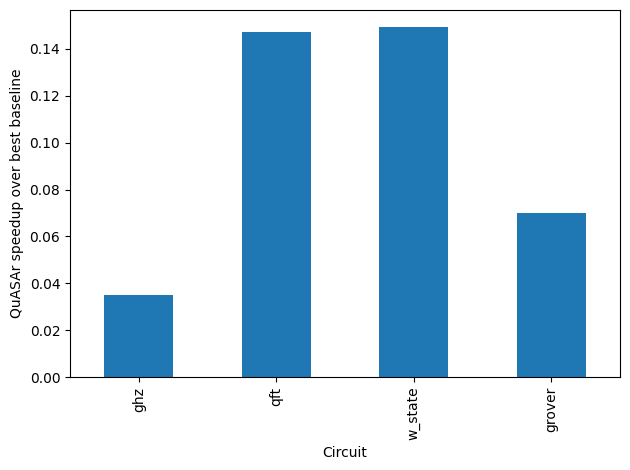

In [6]:
ax = speedup_df.plot.bar(x='circuit', y='speedup', legend=False)
ax.set_ylabel('QuASAr speedup over best baseline')
ax.set_xlabel('Circuit')
plt.tight_layout()

In [7]:
import pandas as pd
from benchmarks.stats_utils import stats_table

def add_stats(df, quasar_col='QuASAr', baseline_cols=None, test='ttest', correction='bonferroni'):
    """Compute statistics comparing QuASAr with baselines.

    Parameters
    ----------
    df : pandas.DataFrame
        DataFrame with per-circuit results. One column must correspond to QuASAr,
        others to baselines.
    quasar_col : str
        Name of the column containing QuASAr results.
    baseline_cols : list[str] | None
        Columns to treat as baselines. Defaults to all columns except quasar_col.
    test : str
        'ttest' or 'wilcoxon'.
    correction : str
        'bonferroni' or 'fdr_bh'.

    Returns
    -------
    pd.DataFrame
        Table with baseline name, statistic, corrected p-value, and effect size.
    """
    if baseline_cols is None:
        baseline_cols = [c for c in df.columns if c != quasar_col]
    baselines = {c: df[c] for c in baseline_cols}
    return stats_table(df[quasar_col], baselines, test=test, correction=correction)

# Example usage after computing results DataFrame named `results_df`:
# stats_df = add_stats(results_df)
# stats_df


In [ ]:

# Record parameters and results
import json, pathlib
try:
    import ipynbname
    nb_name = ipynbname.path().stem
except Exception:  # pragma: no cover
    nb_name = 'notebook'

# Collect simple parameters from globals
_params = {
    k: v for k, v in globals().items()
    if not k.startswith('_') and isinstance(v, (int, float, str, bool, list, dict, tuple))
}
pathlib.Path('../results').mkdir(exist_ok=True)
with open(f"../results/{nb_name}_params.json", 'w') as f:
    try:
        json.dump(_params, f, indent=2, default=str)
    except TypeError:
        pass
if 'results' in globals():
    try:
        with open(f"../results/{nb_name}_results.json", 'w') as f:
            json.dump(results, f, indent=2, default=str)
    except TypeError:
        pass
try:
    print(json.dumps(_params, indent=2))
except TypeError:
    print(_params)
